# Imaging Genomics of Glioblastoma III

<p  style="text-align:justify">In this project, we analyze paired genomic and imaging data from the Glioblastoma cohort in The Cancer Genome Atlas (TCGA) and The Cancer Imaging Atlas (TCIA) to explore possible associations between imaging and genomic features. 
    
This is situated in the field of radiogenomics which aims at studying possible associations between imaging and genomics with the goal of predicting genomic features using imaging studies. This is extremely desirable given that imaging studies are painless and easily obtained, whereas obtaining genomic features is risky, expensive, and not always possible.<br><br>
In this notebook, we use Canonical Correlation Analysis (CCA) to obtain a low-dimensional representation of the imaging features that is correlated with genomic features and then check if we can genomically stratify cancer patients using these imaging low-dimensional representations
<br>
<br>
Imaging features were obtained from [2]. Mutation data was downloaded from TCGA [3].
    </p>
<br>
We have 102 subjects with imaging features (N = 704), 57 subjects with imaging and mutation data, and 101 subjects with imaging and clinical data.

<br>
We start by loading the necessary libraries and matrix with imaging features:

In [1]:
options(warnings=-1)
#Input file
# X file
filepath.x <- "data/data_glioblastoma_3/"
filename.x <- "matrix_radiomics_57.txt"
header.x <- TRUE
#Y file
filepath.y <- "data/data_glioblastoma_3/"
filename.y <- "matrix_mutation_9.txt"
header.y <- TRUE
#Output file
filepath.out <- getwd()

##########Parameters for rCCA##########

#Number of canonical variate pairs
rcca.keep = 2

##Loads data matrix X
data.x <- read.table(paste(filepath.x, filename.x, sep=""), sep="\t", header=header.x)
##Loads data matrix Y
data.y <- read.table(paste(filepath.y, filename.y, sep=""), sep="\t", header=header.y)


##Load libraries
suppressPackageStartupMessages(library(mixOmics))
suppressPackageStartupMessages(library(magrittr))
suppressPackageStartupMessages(library(tidyr))


We apply CCA to compute a low-dimensional representation of the imaging features
We use cross-validation to find the optimal value of the regularization parameters

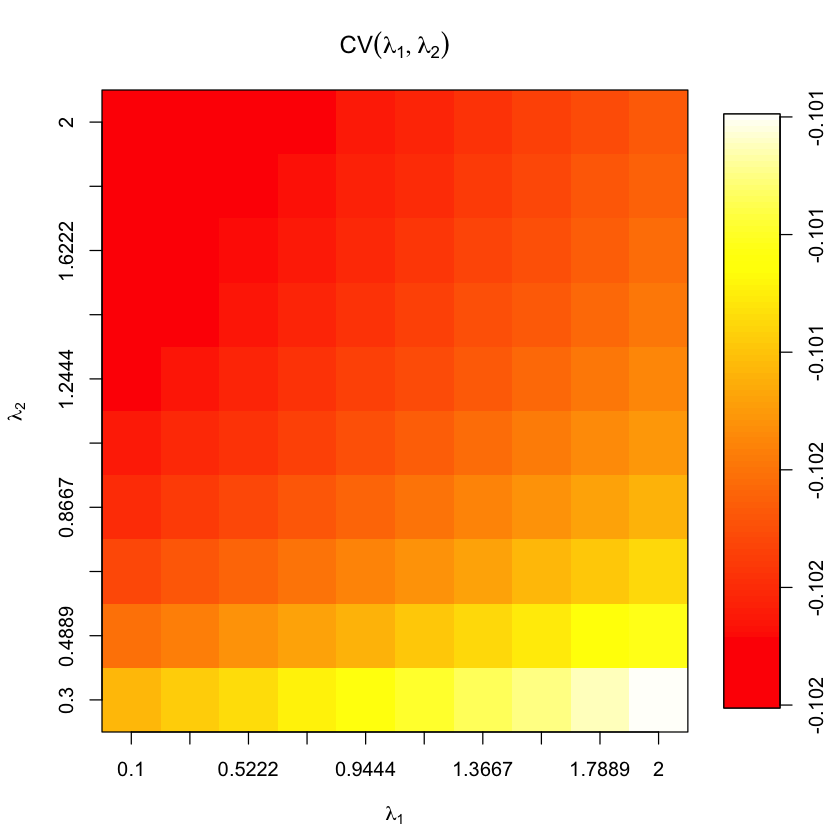

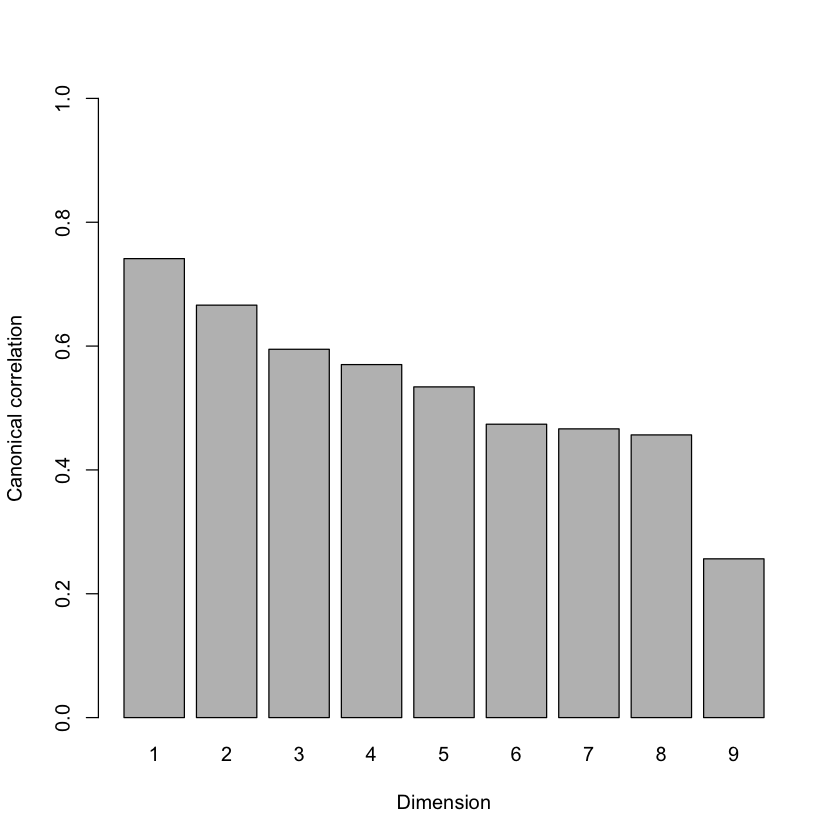

In [2]:

# Info in: http://mixomics.org/methods/rcca/
#Canonical Correlation Analysis (CCA) is a multivariate exploratory approach to highlight correlations between 
#two data sets acquired on the same experimental units. 
#In the same vein as PCA, CCA seeks for linear combinations of the variables (called canonical variates) to 
#reduce the dimensions of the data sets, but this time while trying to maximize the correlation between the 
#two variates (the canonical correlation).

# #Grids to test regularization parameters 
min.x <- 0.1
max.x <- 2
length.x <- 10

min.y <- 0.3
max.y <- 2
length.y <- 10 


# #Estimation of penalisation parameters by CV
grid1 <- seq(min.x, max.x, length = length.x) 
grid2 <- seq(min.y, max.y, length = length.y)
#cv function to find optimal values of parameters
rcca.cv <- tune.rcc(data.x, data.y, grid1 = grid1, grid2 = grid2, validation = "loo")

#rCCA with best parameters
# rcca.result <- rcc(data.x, data.y, ncomp = rcca.keep, lambda1 = 1.786, lambda2 = 0.109)
rcca.result <- rcc(data.x, data.y, ncomp = rcca.keep, lambda1 = rcca.cv$opt.lambda1, lambda2 = rcca.cv$opt.lambda2)

#Scree plot to visualise number of rCCA dimensions and the canonical correlation
plot(rcca.result, scree.type = "barplot")



The scree plot above shows the correlations of the imaging dimensions computed and the genomic features. We keep the first 2 and use them as X and Y axes for visualization and apply a colormap with the mutation status of the genes

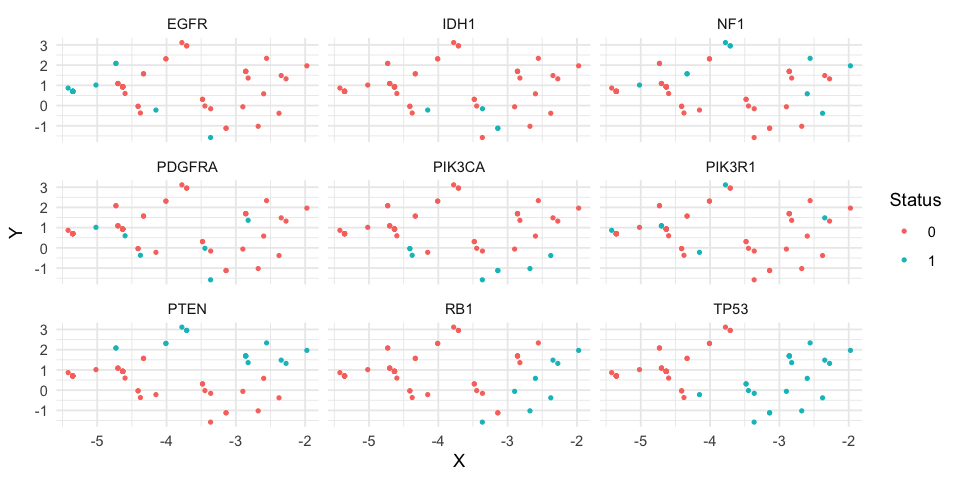

In [3]:
#Loads mutation data
mut <- data.y

#Transform samples data to new space
transformed_data.x <- c()
transformed_data.y <- c()
colnames(data.x) <- NULL
colnames(rcca.result$loadings$X) <- NULL
rownames(data.x) <- NULL
rownames(rcca.result$loadings$X) <- NULL

for (i in 1:dim(data.x)[1]){
    transformed_data.x <- append(transformed_data.x, c(unlist(data.x[i,])) %*% c(rcca.result$loadings$X[,1]) )
    transformed_data.y <- append(transformed_data.y, c(unlist(data.x[i,])) %*% c(rcca.result$loadings$X[,2]))
    }


#Data
data <- cbind(transformed_data.x, transformed_data.y )
colnames(data) <- c('X', 'Y')
rownames(data) <- row.names(mut)

#Binds rCCA features and mutation data
matrix <- cbind(data, mut)

#Converts mut to factor type
for (col in c("TP53","RB1","NF1","PIK3CA","PTEN","EGFR","PDGFRA", "IDH1", "PIK3R1")){
matrix[,col] <- as.factor(matrix[,col] )
}

#Tidy matrix for visualization
matrix.tidy <- matrix %>% gather( Gene, Status, c(3:ncol(matrix)))

#Plot
options(repr.plot.width=8, repr.plot.height=4)


ggplot(matrix.tidy, aes(x=X, y=Y)) +
          geom_point(size = 0.8, stat="identity", aes(colour=Status))+
          facet_wrap( ~Gene)+
          theme_minimal()

A clearly defined grouping of samples can be observed for genes PIK3CA, PTEN, TP53, and RB1. 


### Conclusions

<p  style="text-align:justify; line-height:2; margin: 3px">
• A 2-dimensional map of the 704 imaging features was computed, with the dimensions optimized to be as correlated as possible with the genomic features<br>
• Labeling with the mutation status of genes studied showed patient grouping for genes PIK3CA, PTEN, TP53, and RB1 <br>
• We have provided a proof of concept in radiogenomics, showing that by using radiomic (high-dimensional) features and dimensionality-reduction techniques, patients can be stratified for some of the genes of interest. Our results are of great interest given that treatments are recommended based on the genomic stratification, and they open the door for further studies using similar methodologies


</p>

# References
[1] Gonzalez Pigorini G. Association of radiological and genomic features for cancer stratification [MRes Biomedical Research (Data Science)]. Imperial College London; 2018. 
<br>
<br>
[2] Spyridon Bakas, Hamed Akbari, Aristeidis Sotiras, Michel Bilello, Martin Rozycki, Justin S. Kirby, John B. Freymann, Keyvan Farahani, and Christos Davatzikos. Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features. Scientific Data, 4(September):170117, 2017. URL http://www.nature.com/articles/sdata2017117.
<br>
<br>
[3] GDC [Internet]. Portal.gdc.cancer.gov. 2018 [cited 2 April 2018]. Available from: https://portal.gdc.cancer.gov/exploration?filters=%7B%22op%22%3A%22AND%22%2C%22content%22%3A%5B%7B%22op%22%3A%22IN%22%2C%22content%22%3A%7B%22field%22%3A%22cases.case_id%22%2C%22value%22%3A%5B%22set_id%3AAWJSvsz3Wcjtn2KP3xMl%22%5D%7D%7D%5D%7D&searchTableTab=genes

